# Stock Prices Prediction Project

**Description**. In this project I will select 2 publicly listed companies, get data on their stock prices for some years, analyse the data, and build a model able to predict stock prices based on historical values. Of course, I will validate the model and apply it to prediction of some new values.

I start by importing some popular libraries needed for this project.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import random
import yfinance

## Get the Data

I selected 2 famous pharmaceutical companies for this project:
1. Pfizer Inc.
2. AstraZeneca PLC

Both of them have long history. A couple of years ago both of them invented COVID-19 vaccines (Comirnaty and Covishield respectively) and started mass production. Let's explore how stock prices of these companies changed during 5-year period and build a model able to make short-term predictions for stock prices.

Also, I selected NYSE Arca Pharmaceutical Index as industry index in order to compare Pfizer and AstraZeneca performance with some industry average. By the way, both Pfizer and AstraZeneca are included in the abovementioned index.

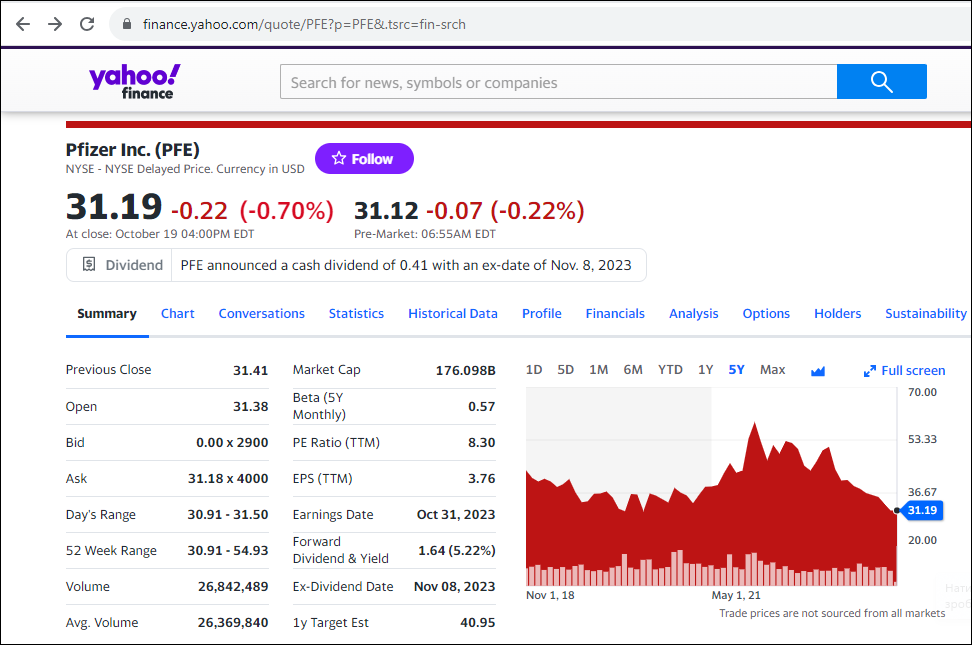

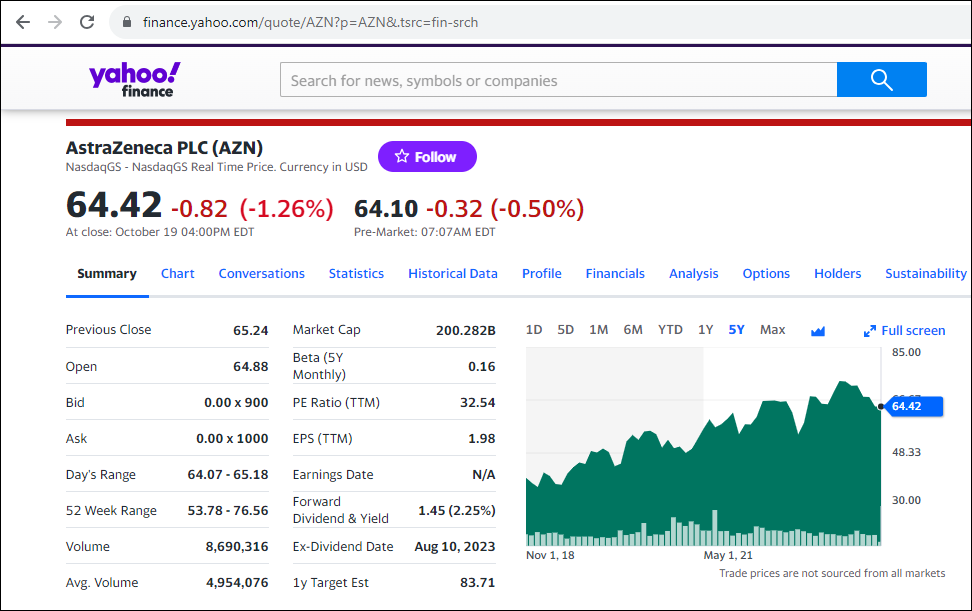

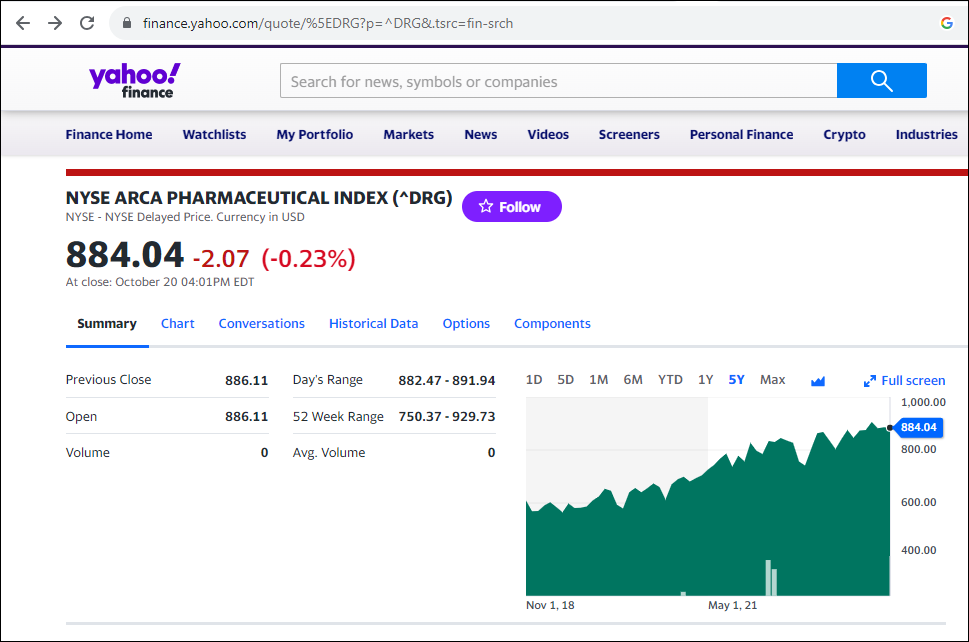

In [2]:
company_1 = 'Pfizer'
company_2 = 'AstraZeneca'
pharma_industry_index = 'NYSE Arca Pharmaceutical Index'

I created the function able to get stock prices and trade volumes as at all trading dates during certain period from Yahoo Finance.

In [3]:
def collect_data(symbol, start, end):
    df = yfinance.download(symbol, start, end)
    return df

I used this function to get stock prices for 2 selected companies for 5-year period up to the date of preparation of this project.

In [4]:
end = datetime.datetime.today()
start = end - datetime.timedelta(365*5)

In [5]:
df_1 = collect_data('PFE', start, end)
df_1.reset_index(inplace=True)
df_2 = collect_data('AZN', start, end)
df_2.reset_index(inplace=True)
df_pharma_industry_index = collect_data('^DRG', start, end)
df_pharma_industry_index.reset_index(inplace=True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Explore the Data

Let's have a look how data looks like.

In [6]:
# Before that I suggest setting global 2-digit float precision for better readability
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [7]:
df_1.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-10-23,41.64,42.05,41.45,41.84,34.76,23073114
1,2018-10-24,41.57,42.02,40.19,40.30,33.48,36927206
2,2018-10-25,40.22,41.69,39.53,41.19,34.21,38600642


In [8]:
df_2.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-10-23,39.16,39.76,39.03,39.59,34.67,4603400
1,2018-10-24,39.42,39.42,37.79,37.86,33.16,5809500
2,2018-10-25,36.93,38.07,36.67,37.78,33.09,5385300


In [9]:
df_pharma_industry_index.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-10-23,582.16,583.14,573.95,580.97,580.97,0
1,2018-10-24,578.58,581.15,561.60,562.37,562.37,0
2,2018-10-25,557.71,572.40,554.55,568.81,568.81,0


There are 4 types of stock prices, but I'm interested only in high and low ones, because in this project I will use average price being mean between high and low prices.

Let's have a closer look at the data. The first and the most simple thing to do is to check out main statistical measures for both datasets.

In [10]:
df_1.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1257.00,1257.00,1257.00,1257.00,1257.00,1257.00
mean,40.81,41.23,40.36,40.79,37.46,28140293.19
std,6.43,6.56,6.32,6.46,7.00,15150054.11
min,27.29,28.06,26.45,27.03,23.71,5187683.00
25%,35.93,36.22,35.59,35.86,32.09,19434800.00
50%,39.62,39.93,39.27,39.61,35.10,24262553.00
75%,44.72,45.14,44.15,44.71,42.84,31931352.00
max,60.60,61.71,59.83,61.25,57.51,230153864.00


In [11]:
df_2.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1257.00,1257.00,1257.00,1257.00,1257.00,1257.00
mean,55.27,55.70,54.83,55.26,52.43,5990377.72
std,10.28,10.35,10.22,10.28,11.56,4711171.27
min,35.56,35.63,35.30,35.49,31.08,755800.00
25%,48.07,48.50,47.63,48.06,43.80,3578100.00
50%,55.69,55.96,55.08,55.41,52.38,4918500.00
75%,64.22,64.84,63.77,64.36,63.03,6950900.00
max,76.50,76.56,75.66,75.81,75.32,65540200.00


Let's examine high and low stock prices distribution in both datasets.

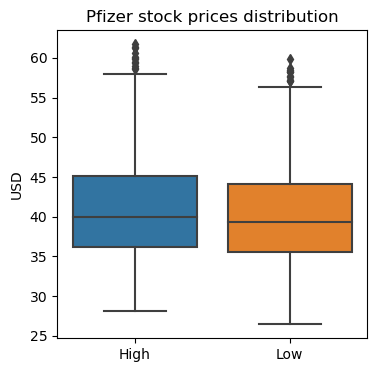

In [12]:
plt.figure(figsize=(4,4))
sns.boxplot(df_1[['High','Low']]).set(title=f'{company_1} stock prices distribution', ylabel='USD');

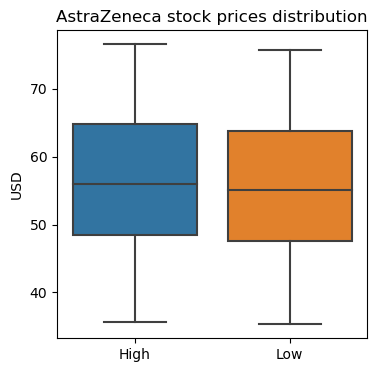

In [13]:
plt.figure(figsize=(4,4))
sns.boxplot(df_2[['High','Low']]).set(title=f'{company_2} stock prices distribution', ylabel='USD');

As we see, Prizer dataset has some outliers, but they are very close to other observations. AstraZeneca dataset has no outliers.

Now I'm going to proceed with creating new column 'Average' for further use in training and validation.

In [14]:
df_1['Average'] = (df_1['High'] + df_1['Low']) / 2
df_2['Average'] = (df_2['High'] + df_2['Low']) / 2
df_pharma_industry_index['Average'] = (df_pharma_industry_index['High'] + df_pharma_industry_index['Low']) / 2

Now I can create a function extracting data necessary data from dataframes. Actually I need only dates and average prices.

In [15]:
def select_data(df):
    time = df['Date'].to_numpy()
    series = df['Average'].to_numpy()
    series_volume = df['Volume'].to_numpy()
    return time, series, series_volume

Then I applied this function to respective dataframes and checked how many observations were collected from Yahoo Finance.

In [16]:
time_1, series_1, series_volume_1 = select_data(df_1)
print(f'{company_1} dataset contains {len(time_1)} observations')
time_2, series_2, series_volume_2 = select_data(df_2)
print(f'{company_2} dataset contains {len(time_2)} observations')
time_pharma_industry_index, series_pharma_industry_index, series_volume_pharma_industry_index = select_data(df_pharma_industry_index)
print(f'{pharma_industry_index} dataset contains {len(time_pharma_industry_index)} observations')

Pfizer dataset contains 1257 observations
AstraZeneca dataset contains 1257 observations
NYSE Arca Pharmaceutical Index dataset contains 1257 observations


The next step is to create a universal function for plotting time-series data. It will be used for illustrating actual stock prices 5-year dynamics, comparing actual and predicted prices in validation section, and forecasting new stock prices for certain period in future.

In [17]:
def plot_time_series(time, series, series_volume=None, title=None, xlabel=None, ylabel=None, legend=None):
    # Setup chart dimensions
    plt.figure(figsize=(10,4))
    
    # Get the current axes
    ax = plt.gca()
    
    # In case of short-term charts I want to show only dates
    if len(series) <= 30:
        ax.xaxis.set_major_locator(mpl.dates.DayLocator(interval=4))
        ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%b-%d'))
    
    # Otherwise I want to see years and months
    else:
        ax.xaxis.set_minor_locator(mpl.dates.MonthLocator([1, 7]))
        ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%b'))
        ax.xaxis.set_major_locator(mpl.dates.YearLocator())
        ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y'))
    
    # Decrease label size for both axes
    ax.tick_params(axis='both', which='minor', labelsize=9)
    ax.tick_params(axis='both', which='major', labelsize=9)

    # Plot the chart
    if type(series) is tuple:
        for item in series:
            plt.plot(time, item)
    else:
        plt.plot(time, series)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the title
    plt.title(title)

    # Set the legend if needed
    if legend:
        plt.legend(legend)
    
    # Add trading volumes as second y-axis if needed
    if series_volume is not None:
        ax2 = ax.twinx()
        ax2.set_ylabel('Volume')
        ax2.bar(time, series_volume, color='tab:red')
        ax2.tick_params(axis='y', which='major', labelsize=9)
    
    # Overlay a grid on the chart
    plt.grid(True)

    # Draw the chart on screen
    plt.show()

Let's apply this function to both datasets.

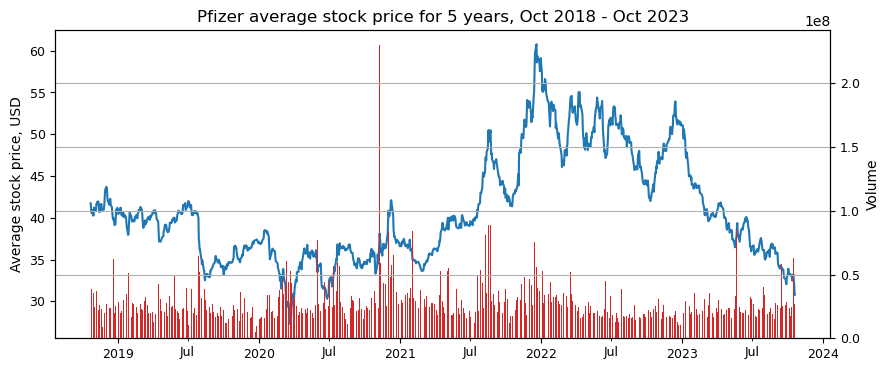

In [18]:
plot_time_series(time_1, series_1, series_volume_1, title=f'{company_1} average stock price for 5 years, Oct 2018 - Oct 2023', ylabel='Average stock price, USD')

During last 5 years Pfizer stock price dynamics demonstrated ups and downs. In 2021 and 2022, benefited from strong demand for its COVID-19 products, but that trend has now reversed. On 5 May 2023, World Health Organization declared end to pandemic, so sales of vaccines decreased significantly. 

Peak trading volumes in October 2021 were achieved against the backdrop of news about Food and Drug Administration authorization of COVID-19 vaccine use for children.

In August 2023, Pfizer's CEO declared plans to launch 19 new products in the next 18 months, so analysts believe that stock price trend may become upward again. Moreover, recently Pfizer made several acquisitions of various pharmaceutical companies, and this can be another growth factor for the company's stock in upcoming years.

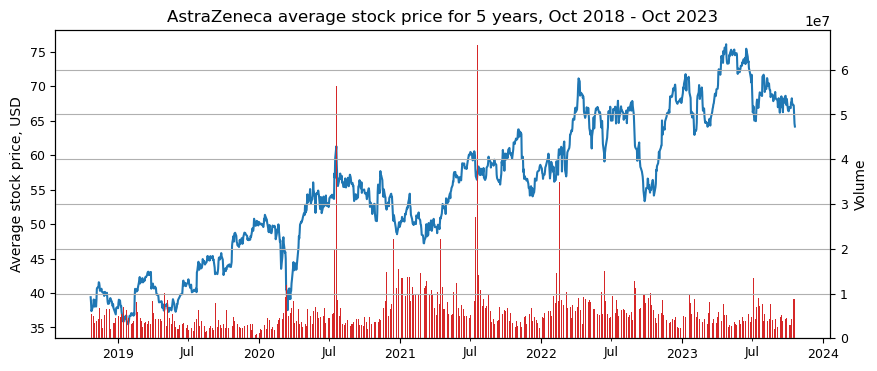

In [19]:
plot_time_series(time_2, series_2, series_volume_2, title=f'{company_2} average stock price for 5 years, Oct 2018 - Oct 2023', ylabel='Average stock price, USD')

During last 5 years AstraZeneca PLC stock price doubled. The boost can be explained by the following factors:
1. The company demonstrates 2-digit revenue growth rates during several years.
2. The company was one of the first to develop COVID-19 vaccine in early 2020.

Peak trading volumes in July 2020 were achieved against the backdrop of good news about COVID-19 vaccine, including good results of vaccine trial (Phase I/II) and agreements for supply of more than 2 billion doses to the US, UK, India and some vaccine alliances. Peak trading volumes in July 2021 were achieved mainly due to successful completion of $39 billion dollar acquisition of rare drug firm Alexion Pharmaceuticals by AstraZeneca.

AstraZeneca stock price trend is likely to remain upward with a view to optimistic revenue forecast for 2024 and CEO's announcement of launch of 15 new products by 2030.

Now let's check NYSE Arca Pharmaceutical Index for the same period and understand how Pfizer and AstraZeneca performed as compared with pharmaceutical industry. 

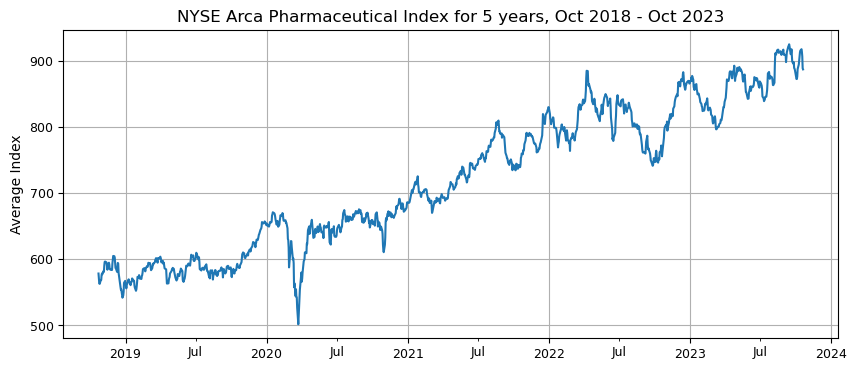

In [20]:
plot_time_series(time_pharma_industry_index, series_pharma_industry_index, title=f'{pharma_industry_index} for 5 years, Oct 2018 - Oct 2023', ylabel='Average Index')

As we can see, during all 5 years pharmaceutical industry index was growing. And AstraZeneca stock price dynamics was in line with pharmaceutical industry in general. However, Pfizer stock price wasn't with a view to factors I mentioned above.

In [21]:
# In the following sections I will need max and min prices. Let's create respective variables now.
max_price_company_1 = round(np.max(series_1),2)
min_price_company_1 = round(np.min(series_1),2)
max_price_company_2 = round(np.max(series_2),2)
min_price_company_2 = round(np.min(series_2),2)

## Split the Data

Now I'm going to create a function splitting time-series data into training and validation sets. My approach to split is 80/20.

In [22]:
def train_validation_split(time, series):
    # Define the split time
    split_time = int(len(time)*4/5)

    # Get the train set
    time_train = time[:split_time]
    series_train = series[:split_time]

    # Get the validation set
    time_valid = time[split_time:]
    series_valid = series[split_time:]
    
    return time_train, series_train, time_valid, series_valid, split_time

Let's apply this function to time-series data in both datasets and check how many items training and validation sets contain.

In [23]:
time_train_1, series_train_1, time_valid_1, series_valid_1, split_time_1 = train_validation_split(time_1, series_1)
print(f'{company_1} traning set contains {len(time_train_1)} observations')
print(f'{company_1} validation set contains {len(time_valid_1)} observations')
time_train_2, series_train_2, time_valid_2, series_valid_2, split_time_2 = train_validation_split(time_2, series_2)
print(f'{company_2} traning set contains {len(time_train_2)} observations')
print(f'{company_2} validation set contains {len(time_valid_2)} observations')

Pfizer traning set contains 1005 observations
Pfizer validation set contains 252 observations
AstraZeneca traning set contains 1005 observations
AstraZeneca validation set contains 252 observations


## Prepare Features and Labels

Next I'm going to perform windowing, namely to group series of consecutive values (features) and to use these groups to predict future series values (labels). By moving such window 1 element at a time I can create many features and labels. I will create a function able to do this below. Function parameters will be presented separately so that they can be tweaked later if necessary.  

In [24]:
window_size = 80
batch_size = 32
output_steps = 20

Parameter output_steps means how many consecutive values a model will be able to predict. Any steps number can be set here, but we should remember that more steps mean lower accuracy and vice versa. For my project I set 20 steps, i.e. 20 future values for 20 consecutive trading days will be predicted by the model. Trading days are stock exchange working days, so 20 trading days = 28 calendar days or even more in case of any holidays when stock exchanges are closed. Every year there are approximately 10 holidays when stock exchanges are closed. So 20-step prediction can be considered as a prediction for 1 calendar month.

In [25]:
def windowed_dataset(series, window_size, batch_size):
    # Generate tensorflow dataset from series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-output_steps], window[-output_steps:]))

    # Shuffle the windows
    dataset = dataset.shuffle(buffer_size=len(series))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

Let's apply this function to training datasets.

In [26]:
# Generate the dataset windows
train_set_1 = windowed_dataset(series_train_1, window_size, batch_size)
train_set_2 = windowed_dataset(series_train_2, window_size, batch_size)

## Building the Model

I suggest CNN as the first layers in the model architechture because they are good at finding short-term patterns in time-series data, like small fluctuations or trends.

Next I'm going to include LSTM layers which are considered one of the best options for time series forecasting. LSTM-based model implement cell state that allows it to remember sequences better than simple RNN models.

Normally, Dense layer is the last layer for output. However, LSTM's activation function is tahn and its output is between -1 and 1. So scaling up the output in the last Lambda layer is needed to achieve output values comparable to the ones in labels. I chose maximum stock price as a scaler.

In [27]:
def model(scaler):
    # Build the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=output_steps*4, kernel_size=3, strides=1, activation="relu", padding='causal', dilation_rate=1, input_shape=[window_size, 1]),
        tf.keras.layers.Conv1D(filters=output_steps*4, kernel_size=3, strides=1, activation="relu", padding='causal', dilation_rate=2),
        tf.keras.layers.Conv1D(filters=output_steps*4, kernel_size=3, strides=1, activation="relu", padding='causal', dilation_rate=4),
        tf.keras.layers.LSTM(units=output_steps*4, return_sequences=True),
        tf.keras.layers.LSTM(units=output_steps*4),
        tf.keras.layers.Dense(units=output_steps*2, activation="relu"),
        tf.keras.layers.Dense(units=output_steps),
        tf.keras.layers.Lambda(lambda x: x*scaler)
    ])

    return model

Now I can build the model for Pfizer and print the model summary.

In [28]:
model_1 = model(max_price_company_1)
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 80, 80)            320       
                                                                 
 conv1d_1 (Conv1D)           (None, 80, 80)            19280     
                                                                 
 conv1d_2 (Conv1D)           (None, 80, 80)            19280     
                                                                 
 lstm (LSTM)                 (None, 80, 80)            51520     
                                                                 
 lstm_1 (LSTM)               (None, 80)                51520     
                                                                 
 dense (Dense)               (None, 40)                3240      
                                                                 
 dense_1 (Dense)             (None, 20)                8

Similarly I can build the model for AstraZeneca. The model architechture is the same, so I will not print it.

In [29]:
model_2 = model(max_price_company_2)

I will use the same model both for tuning learning rate and training, so I should save initial weights to be able to reset the model later.

In [30]:
init_weights_1 = model_1.get_weights()
init_weights_2 = model_2.get_weights()

## Tune the Learning Rate

In order to achieve as good model performance as possible, I'm going to tune learning rate, namely to find optimal one. As you can see below, I can achieve this goal during 120 epochs and be sure that the optimal rate was found.

In [31]:
epochs_for_learning_rate = 120

In [32]:
def tune_learning_rate(model, train_set):
    # Set the learning rate scheduler
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10 ** (epoch / 20))

   # Set the training parameters
    model.compile(loss='mse', optimizer='adam')

    # Train the model
    history = model.fit(train_set, epochs=epochs_for_learning_rate, callbacks=[lr_schedule], verbose=0)
    
    return history

In [33]:
learning_rate_history_1 = tune_learning_rate(model_1, train_set_1)
learning_rate_history_2 = tune_learning_rate(model_2, train_set_2)

Let's plot losses for all learning rates.

In [34]:
def plot_learning_rate(history):
    # Define the learning rate scale
    lrs = 1e-5*(10**(np.arange(epochs_for_learning_rate)/20))

    # Set the figure size
    plt.figure(figsize=(10,4))

    # Set the grid
    plt.grid(True)

    # Plot the loss in log scale
    plt.semilogx(lrs,history.history["loss"])

    # Decrease the tickmarks size
    plt.tick_params(labelsize=9)

    # Set the plot boundaries
    plt.axis([1e-5,10,0,1000])
    
    return lrs

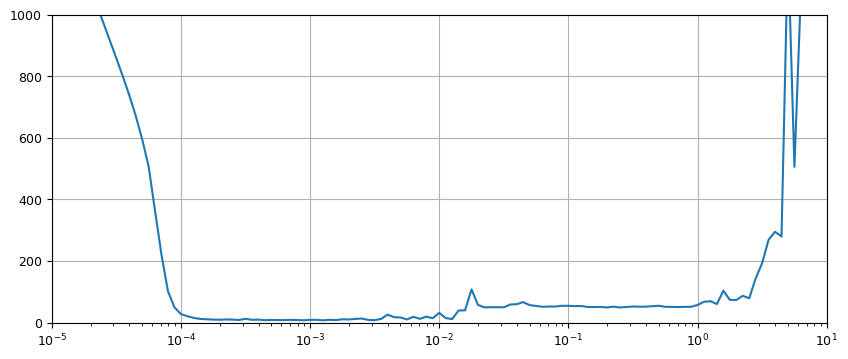

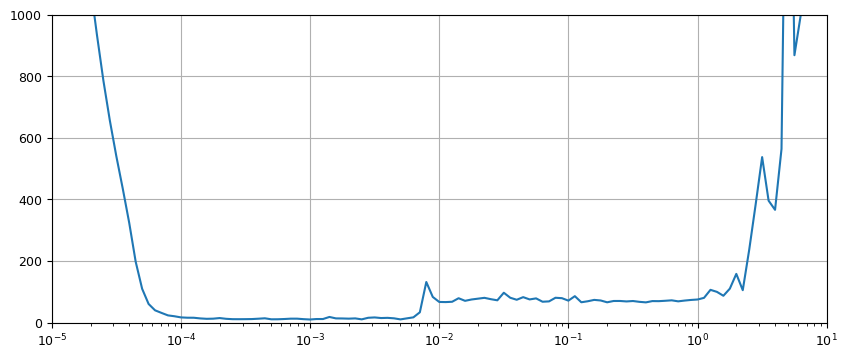

In [35]:
lrs_1 = plot_learning_rate(learning_rate_history_1)
lrs_2 = plot_learning_rate(learning_rate_history_2)

Now I can choose learning rate corresponding to minimal loss.

In [36]:
def optimal_learning_rate_finder(learning_rate_history,lrs):
    # Get the index of minimal learning rate
    optimal_learning_rate_index = np.argmin(np.array(learning_rate_history.history['loss']))
    
    # Get the minimal learning rate itself
    optimal_learning_rate = lrs[optimal_learning_rate_index]
    
    return optimal_learning_rate

In [37]:
optimal_learning_rate_1 = optimal_learning_rate_finder(learning_rate_history_1, lrs_1)
print(f'Optimal learning rate for {company_1} model = {"{:.2e}".format(optimal_learning_rate_1)}')
optimal_learning_rate_2 = optimal_learning_rate_finder(learning_rate_history_2, lrs_2)
print(f'Optimal learning rate for {company_2} model = {"{:.2e}".format(optimal_learning_rate_2)}')

Optimal learning rate for Pfizer model = 1.26e-03
Optimal learning rate for AstraZeneca model = 1.00e-03


## Train the Model

Ok, tuning learning rate is finished, so now I can reset the model based on initial weights.

In [38]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model_1.set_weights(init_weights_1)
model_2.set_weights(init_weights_2)

The next step is to create a function able to compile and train the model. For this project I prefer using Mean Squared Error as loss parameter and Adam as optimizer with a view to better model performance. I also experimented with Huber loss as loss parameter and SGD as optimizer, but the model performance appeared to be slightly worse. Probably it can be explained by the fact that Huber loss is mainly aimed to minimize sensitivity to outliers whereas datasets in this project actually don't have many outliers.

Also, I suggest to use Mean Absolute Error as metrics. Actually it's one of the mose popular metrics for time series forecasting.

In [39]:
epochs_train = 100

In [40]:
def model_compile_train(model, train_set, learning_rate):
    # Set the training parameters
    model.compile(loss='mse', optimizer='adam', metrics=["mae"])
    
    # Train the model
    history = model.fit(train_set, epochs=epochs_train, verbose=0)
    
    return history

In [41]:
history_1 = model_compile_train(model_1, train_set_1, optimal_learning_rate_1)
history_2 = model_compile_train(model_2, train_set_2, optimal_learning_rate_2)

Then I can plot loss and mean absolute error per epoch.

In [42]:
def plot_mae_loss(company, history, zoom_split=0):    
    # Get MAE and loss from history log
    mae = history.history['mae']
    loss = history.history['loss']

    # Get number of epochs
    epochs=range(len(loss))

    # Initialize x and y
    x = epochs[zoom_split:]
    y = (mae[zoom_split:], loss[zoom_split:])

    # Setup chart dimensions
    plt.figure(figsize=(10,4))

    # Plot MAE and loss
    for item in y:
        plt.plot(x, item)

    # Label the axes
    plt.xlabel('Epochs')
    
    # Decrease the tickmarks size
    plt.tick_params(labelsize=9)

    # Set the legend
    plt.legend(['MAE','Loss'])

    # Set the title
    plt.title(f'MAE and Loss for {company}')

    # Overlay a grid on the chart
    plt.grid(True)

    # Draw the chart on screen
    plt.show()

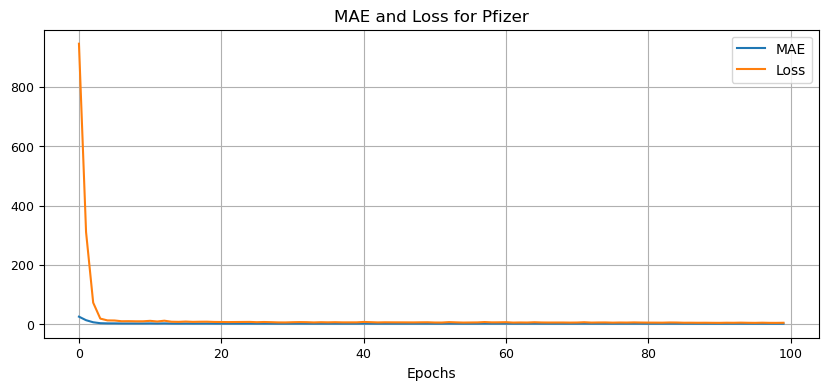

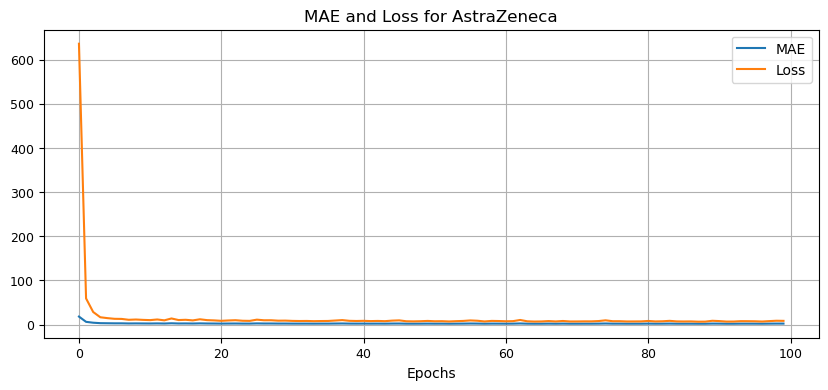

In [43]:
plot_mae_loss(company_1, history_1)
plot_mae_loss(company_2, history_2)

Looks like MAE and loss decrease significantly during a couple of first epochs. Let's zoom in to see what happens after these first epochs.

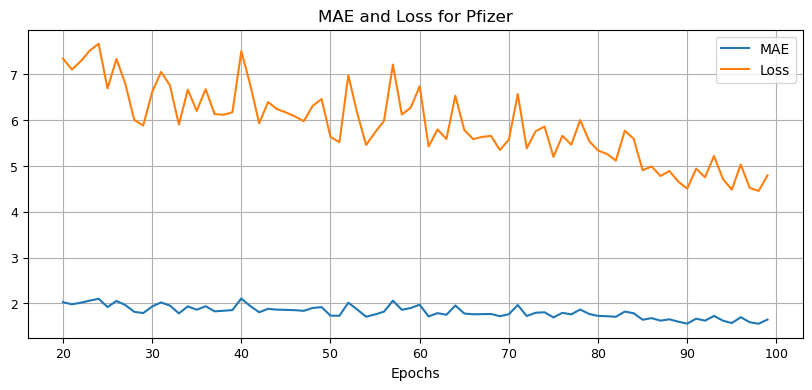

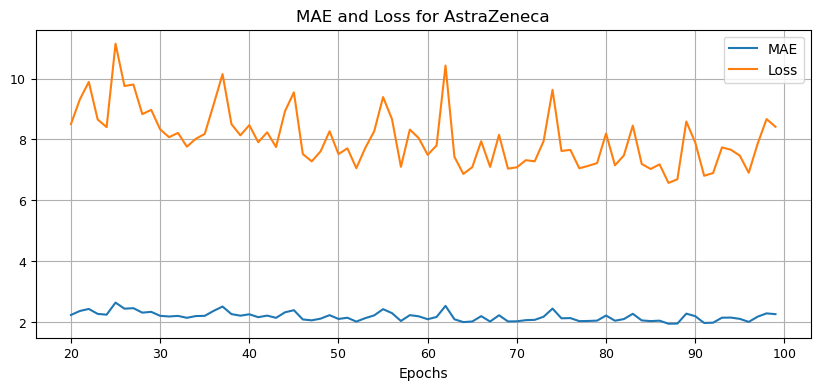

In [44]:
plot_mae_loss(company_1, history_1, 20)
plot_mae_loss(company_2, history_2, 20)

We see that MAE continues to improve but very insignificantly. So 100 epochs is more that enough for training.

## Make Prediction and Validate the Model

Ok, training is finished and I can proceed with creating a prediction function. This function will be used for forecasting series of stock prices for the last year included in the datasets (Oct 2022 - Oct 2023) for further validation of the model, i.e. comparing with actual stock prices for the last year in the datasets). The function is also based on the same windowing technique I used above.

In [45]:
def model_forecast(model, series, window_size, batch_size):
    # Generate tensorflow dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast.squeeze()

Now I can apply this function to both datasets.

In [46]:
forecast_1 = model_forecast(model_1, series_1[split_time_1-window_size:-1-output_steps], window_size, batch_size)
forecast_2 = model_forecast(model_2, series_2[split_time_2-window_size:-1-output_steps], window_size, batch_size)

8/8 [==============================] - 1s 23ms/step


As I expected, the number of predicted series is less then the length of the validation set by 20, i.e. output_step parameter set above.

In [47]:
print(f'{len(forecast_1)} series were predicted for {company_1} validation set')
print(f'{len(forecast_2)} series were predicted for {company_2} validation set')

232 series were predicted for Pfizer validation set
232 series were predicted for AstraZeneca validation set


Now I can proceed with validation of the forecast. As I explained above, I will use mean absolute error (MAE) as evaluation metrics. Plus I will also use mean absolute percentage error (MAPE) because percentage error, unlike absolute error, can give me understading of forecast accuracy of the model. Below I create a function able to calculate MAE and MAPE for each pair of series of actual stock prices and series of predicted stock prices.

In [48]:
def model_forecast_validation(series, forecast_series):
    # Initialize MAE and MAPE lists
    mae = []
    mape = []
    
    # Calculate MAE and MAPE for each pair of series
    for i in range(len(forecast_series)):
        series_valid = series[i:i+output_steps]
        forecast_series_valid = forecast_series[i]
        mae.append(tf.keras.metrics.mean_absolute_error(series_valid,forecast_series_valid).numpy())
        mape.append(tf.keras.metrics.mean_absolute_percentage_error(series_valid,forecast_series_valid).numpy())
    
    return np.array(mae),np.array(mape)

In [49]:
mae_1, mape_1 = model_forecast_validation(series_valid_1, forecast_1)
mae_2, mape_2 = model_forecast_validation(series_valid_2, forecast_2)

Ok, now we have series of MAE and series of MAPE. I suggest to summarize them by calculating max and min MAE and MAPE and overall (average) MAE and MAPE.

In [50]:
def metrics_summary(company, mae, mape):
    bold_start = '\033[1m'
    bold_end = '\033[0m'
    print(f'Evaluation metrics summary for {company} validation set:')
    print(f'Maximum MAE = USD {max(mae):.2f}')
    print(f'Minimum MAE = USD {min(mae):.2f}')
    print(f'{bold_start}Overall MAE = USD {str(np.round(np.mean(mae),2))}{bold_end}')
    print(f'Maximum MAPE = {max(mape):.2f}%')
    print(f'Minimum MAPE = {min(mape):.2f}%')
    print(f'{bold_start}Overall MAPE = {str(np.round(np.mean(mape),2))}%{bold_end}')

In [51]:
metrics_summary(company_1, mae_1, mape_1)
print('\n')
metrics_summary(company_2, mae_2, mape_2)

Evaluation metrics summary for Pfizer validation set:
Maximum MAE = USD 5.04
Minimum MAE = USD 0.37
Overall MAE = USD 1.89
Maximum MAPE = 11.47%
Minimum MAPE = 1.00%
Overall MAPE = 4.68%


Evaluation metrics summary for AstraZeneca validation set:
Maximum MAE = USD 7.30
Minimum MAE = USD 0.98
Overall MAE = USD 3.7
Maximum MAPE = 9.86%
Minimum MAPE = 1.47%
Overall MAPE = 5.26%


As we can see, overall MAPE is low in both cases, so the model performed well. The accuracy reached approximately 95% both for Pfizer and AstraZeneca.

Let's plot a random pair of series of actual and series of predicted stock prices just to have understanding how they look like.

In [52]:
def plot_random_validation(time, series, forecast_series):
    # Generate array random number
    random_num = random.randint(0, len(time)-output_steps)
    
    # Initialize time and series arrays
    time_valid = time[random_num:random_num+output_steps]
    series_valid = series[random_num:random_num+output_steps]
    forecast_series_valid = forecast_series[random_num]
    
    # Plot random pair of series
    plot_time_series(time_valid, (series_valid, forecast_series_valid), title=f'Validation for series #{random_num}', ylabel='Average stock price, USD', legend=['Actual','Forecast'])
    
    # Print evaluation metrics
    print('MAE = USD '+str(round(tf.keras.metrics.mean_absolute_error(series_valid, forecast_series_valid).numpy(),2)))
    print('MAPE = '+str(round(tf.keras.metrics.mean_absolute_percentage_error(series_valid, forecast_series_valid).numpy(),2))+'%')

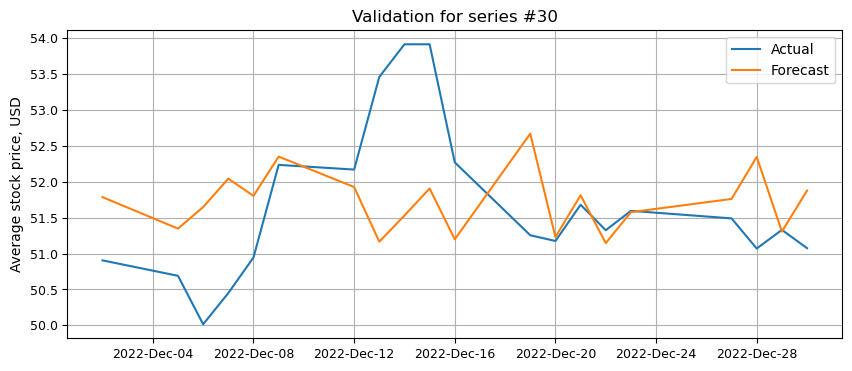

MAE = USD 0.9
MAPE = 1.72%


In [53]:
plot_random_validation(time_valid_1,series_valid_1,forecast_1)

## Make New Prediction

Finally, it's time for forecasting a series of future stock prices, i.e. for the period after completion of this project. First of all, I need to create a series of trading days. As I mentioned above, trading days are stock exchange working days. The list of holidays can be found here:
 - https://www.nyse.com/markets/hours-calendars (relevant for Pfizer as its stock data taken from Yahoo Finance relates to NYSE trading)
 - https://www.nasdaq.com/market-activity/stock-market-holiday-schedule (relevant for AstraZeneca for the similar reason)

In [54]:
# Prepare date range for new prediction
if end.date() == df_1['Date'].iloc[-1].date():
    dates = pd.date_range(end+datetime.timedelta(1), periods=int(output_steps)/5*7)
else:
    dates = pd.date_range(end, periods=int(output_steps)/5*7)

In [55]:
# Create a dataframe of dates
next_days = pd.DataFrame({'Date': dates})

In [56]:
# Create new column showing weekday for each date
next_days['Day of Week'] = next_days['Date'].apply(lambda x: x.weekday())
next_days.head(10)

,Date,Day of Week
0,2023-10-22 14:38:43.565239,6
1,2023-10-23 14:38:43.565239,0
2,2023-10-24 14:38:43.565239,1
3,2023-10-25 14:38:43.565239,2
4,2023-10-26 14:38:43.565239,3
5,2023-10-27 14:38:43.565239,4
6,2023-10-28 14:38:43.565239,5
7,2023-10-29 14:38:43.565239,6
8,2023-10-30 14:38:43.565239,0
9,2023-10-31 14:38:43.565239,1


0 means Monday, 6 means Sunday. We don't need Saturdays, Sundays, and holidays. I followed the links above checked trading days schedules. No holidays fall on the data range for my new prediction.

In [57]:
# Select only working days
trading_days_for_forecast = next_days[next_days['Day of Week']<=4]
trading_days_for_forecast = trading_days_for_forecast.reset_index(drop=True)

Below I created the function able to make prediction of future stock prices.

In [58]:
def model_forecast_future(model, series):
    # Get predictions on windowed series
    forecast_future = model.predict(series[-window_size:][np.newaxis])
    
    return forecast_future

Let's apply the function to both datasets. I expect series containing 20 values as an output.

In [59]:
forecast_future_1 = model_forecast_future(model_1, series_1)
print(f'Predicted forecast for {company_1} has shape: {forecast_future_1.shape}')
forecast_future_2 = model_forecast_future(model_2, series_2)
print(f'Predicted forecast for {company_2} has shape: {forecast_future_2.shape}')

1/1 [==============================] - 1s 741ms/step
Predicted forecast for Pfizer has shape: (1, 20)
1/1 [==============================] - 1s 655ms/step
Predicted forecast for AstraZeneca has shape: (1, 20)


Please see below how predicted future stock prices look like on the charts.

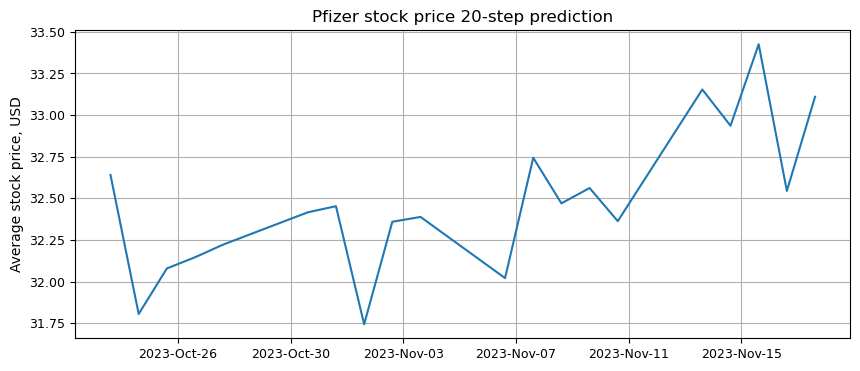

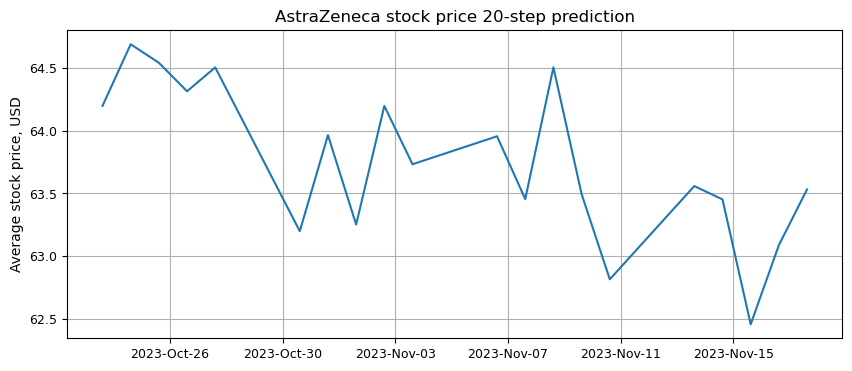

In [60]:
plot_time_series(trading_days_for_forecast['Date'], forecast_future_1.squeeze(), title=f'{company_1} stock price {output_steps}-step prediction', ylabel='Average stock price, USD')
plot_time_series(trading_days_for_forecast['Date'], forecast_future_2.squeeze(), title=f'{company_2} stock price {output_steps}-step prediction', ylabel='Average stock price, USD')

**Conclusion.** The goal of the project was achieved: I have the model able to predict stock prices based on historical values. The model was trained on stock data for 2 companies and performed well reaching 95% accuracy. I believe that the good idea for future experiments is to feed stock data of other companies to this model, to see how it performs and to decide whether any parameters should be tweaked or not.

Thank you for reading up to here :)